## 1. Import Libraries

In [1]:
import os
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt

## 2. MelanomaDetector Class

In [2]:
class MelanomaDetector:
    """
    Simple melanoma detection class.

    Usage:
        detector = MelanomaDetector()
        result = detector.predict("image.jpg")
    """

    def __init__(self, model_path="final_model/melanoma_model_improved_weights.pth", input_size=224):
        """
        Initialize the detector.

        Args:
            model_path: Path to model weights
            input_size: Input image size (default: 224)
        """
        self.input_size = input_size
        self.class_names = ["benign", "suspicious", "melanoma"]
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Create model architecture
        self.model = models.resnet18(pretrained=False)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 3)

        # Load trained weights
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Model weights not found: {model_path}")

        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model = self.model.to(self.device)
        self.model.eval()

        # Setup image preprocessing
        self.transform = transforms.Compose(
            [
                transforms.Resize((self.input_size, self.input_size)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )

        print(f"✓ MelanomaDetector initialized")
        print(f"  Device: {self.device}")
        print(f"  Model: {model_path}")

    def predict(self, image_path, show_image=True):
        """
        Predict melanoma class for an image.

        Args:
            image_path: Path to the image file
            show_image: Whether to display the image with prediction

        Returns:
            dict with 'prediction', 'confidence', and 'probabilities'
        """
        # Load and preprocess image
        image = Image.open(image_path).convert("RGB")
        input_tensor = self.transform(image).unsqueeze(0).to(self.device)

        # Predict
        with torch.no_grad():
            outputs = self.model(input_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]
            confidence, prediction_idx = torch.max(probabilities, dim=0)

        # Get prediction
        prediction = self.class_names[prediction_idx.item()]
        confidence_pct = confidence.item()

        # All class probabilities
        all_probs = {self.class_names[i]: probabilities[i].item() for i in range(len(self.class_names))}

        # Visualize if requested
        if show_image:
            self._visualize(image, prediction, confidence_pct, all_probs, prediction_idx)

        # Return results
        return {"prediction": prediction, "confidence": confidence_pct, "probabilities": all_probs}

    def _visualize(self, image, prediction, confidence, all_probs, prediction_idx):
        """Visualize prediction results."""
        plt.figure(figsize=(12, 5))

        # Show image
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Prediction: {prediction.upper()}\nConfidence: {confidence:.1%}", fontsize=14, fontweight="bold")

        # Show probabilities
        plt.subplot(1, 2, 2)
        colors = ["green", "orange", "red"]
        bars = plt.barh(list(all_probs.keys()), list(all_probs.values()), color=colors)
        plt.xlabel("Probability", fontsize=12)
        plt.title("Class Probabilities", fontsize=12, fontweight="bold")
        plt.xlim(0, 1)

        # Highlight predicted class
        bars[prediction_idx].set_edgecolor("black")
        bars[prediction_idx].set_linewidth(3)

        plt.tight_layout()
        plt.show()


print("✓ MelanomaDetector class defined")

✓ MelanomaDetector class defined


## 3. Initialize Detector

c:\Users\major\Documents\University\DeepLearning\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\major\Documents\University\DeepLearning\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✓ MelanomaDetector initialized
  Device: cpu
  Model: final_model/melanoma_model_improved_weights.pth


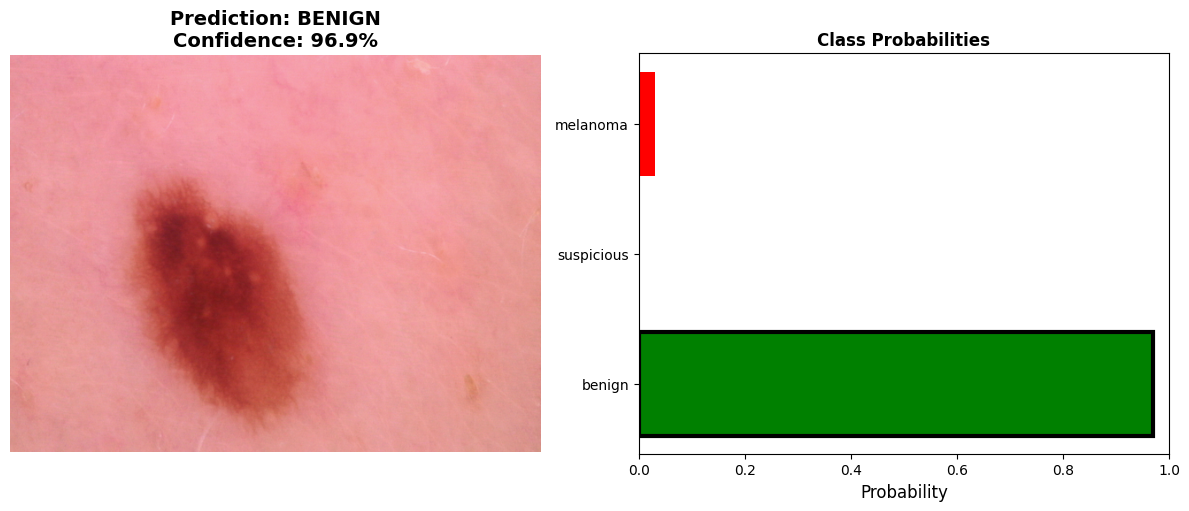

In [3]:
# Initialize the detector (do this once)
detector = MelanomaDetector()
example_image = "data/ham10000/ds/img/ISIC_0024353.jpg"
result = detector.predict(example_image, show_image=True)